# Time Series Forecasting for Tesla (TSLA)
## **Task 2** — Implement and compare ARIMA (classical) and LSTM (deep learning) models to forecast Tesla stock prices.


## 1. Imports, seed, and helper functions


In [1]:
!pip install yfinance tensorflow scikit-learn matplotlib pandas numpy

In [4]:
# Fix NumPy / pmdarima binary mismatch
#!pip install --upgrade --force-reinstall numpy==1.26.4
!pip install --upgrade  pmdarima


  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


In [5]:
# data & ML
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# classical time series
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# helper evaluation
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true==0, 1e-8, y_true))) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


## 2. Download TSLA data
We fetch daily historical *Close* prices from Yahoo Finance.


In [6]:
# define time range
train_start = "2015-01-01"
train_end = "2023-12-31"
test_start = "2024-01-01"
# use system date (as of notebook run). per spec we'll use 2025-08-09 as latest date.
test_end = "2025-08-09"

# download
ticker = "TSLA"
df = yf.download(ticker, start=train_start, end=test_end, progress=False)
if df.empty:
    raise RuntimeError("Empty data returned from yfinance. Check connectivity / ticker.")
df = df[['Close']].rename(columns={'Close':'close'})
df.index = pd.to_datetime(df.index)
df.head()


/tmp/ipython-input-971379559.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=train_start, end=test_end, progress=False)


Price,close
Ticker,TSLA
Date,
2015-01-02,14.620667
2015-01-05,14.006000
2015-01-06,14.085333
2015-01-07,14.063333
2015-01-08,14.041333


## 3. Chronological train/test split
Train: 2015-01-01 → 2023-12-31  
Test: 2024-01-01 → 2025-08-09


Train period: 2015-01-02 to 2023-12-29 -> 2264 rows
Test period: 2024-01-02 to 2025-08-08 -> 402 rows


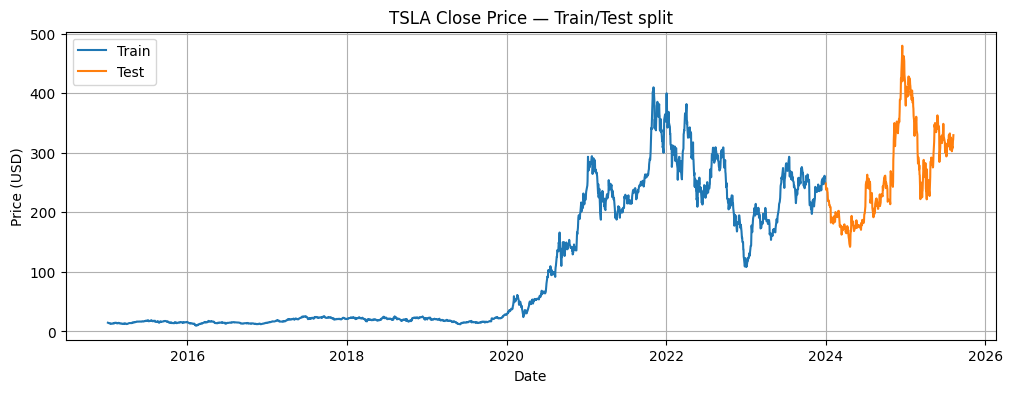

In [7]:
train = df.loc[:train_end].copy()
test = df.loc[test_start:test_end].copy()

print("Train period:", train.index.min().date(), "to", train.index.max().date(), "->", len(train), "rows")
print("Test period:", test.index.min().date(), "to", test.index.max().date(), "->", len(test), "rows")

# plot raw
plt.figure(figsize=(12,4))
plt.plot(train.index, train['close'], label='Train')
plt.plot(test.index, test['close'], label='Test')
plt.title(f'{ticker} Close Price — Train/Test split')
plt.xlabel('Date'); plt.ylabel('Price (USD)')
plt.legend(); plt.grid(True)
plt.show()


## 4. ARIMA / auto_arima modeling
We'll use `pmdarima.auto_arima` to find good (p,d,q) (and seasonal if desired). We'll model the daily close as a univariate series. For speed, use non-seasonal auto_arima first; you can enable seasonal if you expect yearly seasonality (stock daily data can be noisy).


In [8]:
# auto_arima on training 'close' series
# restrict search to reasonable ranges to keep runtime manageable
s = None  # non-seasonal
auto_model = pm.auto_arima(train['close'],
                           seasonal=False,
                           start_p=0, max_p=5,
                           start_q=0, max_q=5,
                           d=None,           # let auto find d
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                           n_jobs=1,
                           random_state=SEED)

print("Auto ARIMA summary:")
print(auto_model.summary())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14311.500, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14311.406, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14311.463, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14310.241, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14311.764, Time=1.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.419 seconds
Auto ARIMA summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7154.121
Date:                Sat, 09 Aug 2025   AIC                          14310.241
Time:                        21:24:35   BIC                          14315.966
Sample:                             0   HQIC                         14312.330
                               - 2264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        32.6169      0.368     88.563   

### Fit final ARIMA model on training set (using chosen parameters)
We will then forecast for the test period length.


In [9]:
# get order found by auto_arima
order = auto_model.order
print("Chosen order:", order)

# fit SARIMAX (statsmodels) with that order for more flexibility
arima_model = SARIMAX(train['close'], order=order, enforce_stationarity=False, enforce_invertibility=False)
arima_res = arima_model.fit(disp=False)
print(arima_res.summary())


Chosen order: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                 2264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7151.453
Date:                Sat, 09 Aug 2025   AIC                          14304.907
Time:                        21:24:35   BIC                          14310.631
Sample:                             0   HQIC                         14306.995
                               - 2264                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        32.6318      0.369     88.522      0.000      31.909      33.354
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):             13306.00
Prob(Q):               

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
# Forecast over test period length (steps = len(test))
n_periods = len(test)
arima_forecast = arima_res.get_forecast(steps=n_periods)
arima_pred = arima_forecast.predicted_mean
arima_index = pd.date_range(start=test.index.min(), periods=n_periods, freq='B')  # business days
# Align forecast index to test index: safer to use test.index directly
arima_pred = pd.Series(arima_pred.values, index=test.index[:n_periods])

# evaluate
arima_mae = mean_absolute_error(test['close'][:n_periods], arima_pred)
arima_rmse = rmse(test['close'][:n_periods], arima_pred)
arima_mape = mape(test['close'][:n_periods], arima_pred)

print(f"ARIMA MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")


ARIMA MAE: 63.0207, RMSE: 77.7780, MAPE: 24.03%


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## 5. LSTM modeling
We'll:
1. Scale close prices (MinMax).
2. Create sequences (e.g., 60-day lookback -> predict next day).
3. Build a simple LSTM and train using early stopping.


In [11]:
from sklearn.preprocessing import MinMaxScaler

# prepare series
series = pd.concat([train['close'], test['close']])
scaler = MinMaxScaler()
scaler.fit(train[['close']])

# function to create sequences
def create_sequences(values, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(values)):
        X.append(values[i-seq_len:i])
        y.append(values[i])
    return np.array(X), np.array(y)

SEQ_LEN = 60  # 60 days lookback

# scale train and test separately for sequences
train_scaled = scaler.transform(train[['close']]).flatten()
test_scaled = scaler.transform(test[['close']]).flatten()

# create sequences from the combined series but ensure separation
# for LSTM training, create sequences from train_scaled only
X_train, y_train = create_sequences(train_scaled, seq_len=SEQ_LEN)

# For forecasting the test set sequentially we will use a rolling prediction approach:
# Build X_test where each test sample uses the previous SEQ_LEN actual+predicted scaled values.


In [12]:
# reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(-1, 1)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)


X_train shape: (2204, 60, 1) y_train shape: (2204, 1)


### LSTM model architecture and training


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, LayerNormalization, Dropout, Dense, GaussianNoise
import tensorflow as tf

model = Sequential([
    GaussianNoise(0.01, input_shape=(SEQ_LEN, 1)),

    Bidirectional(LSTM(128, return_sequences=True)),
    LayerNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False)),
    LayerNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 60, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,561 (1.17 MB)

 Trainable params: 306,561 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# callbacks
es = EarlyStopping(monitor='loss', patience=100, restore_best_weights=True, verbose=1)

# train
history = model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[es], verbose=1)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 280ms/step - loss: 0.2867 - mae: 0.5559
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - loss: 0.0134 - mae: 0.1189
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - loss: 0.0100 - mae: 0.0937
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - loss: 0.0083 - mae: 0.0823
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 293ms/step - loss: 0.0081 - mae: 0.0800
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 271ms/step - loss: 0.0062 - mae: 0.0704
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - loss: 0.0044 - mae: 0.0599
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 270ms/step - loss: 0.0043 - mae: 0.0579
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 22s 295ms/step - loss: 0.0034 - mae: 0.0520
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 19s 272ms/step - loss: 0.0039 - mae: 0.0543
Restoring model weights from the end of the best epoch: 10.


### Forecasting on test set
We use the last `SEQ_LEN` points from train to start, then step through test dates predicting one day at a time, appending predictions into the rolling window.


In [37]:
# Prepare initial input: last SEQ_LEN scaled values from train, flattened
last_train_seq = train_scaled[-SEQ_LEN:].flatten().tolist()
predictions_scaled = []

for i in range(len(test_scaled)):
    x_input = np.array(last_train_seq[-SEQ_LEN:]).reshape(1, SEQ_LEN, 1)
    pred_scaled = model.predict(x_input, verbose=0)[0][0]
    predictions_scaled.append(pred_scaled)
    last_train_seq.append(pred_scaled)  # Append prediction for next step input

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1,1)).flatten()
lstm_pred = pd.Series(predictions, index=test.index[:len(predictions)])

# Define RMSE and MAPE if not already
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate
lstm_mae = mean_absolute_error(test['close'][:len(predictions)], lstm_pred)
lstm_rmse = rmse(test['close'][:len(predictions)], lstm_pred)
lstm_mape = mape(test['close'][:len(predictions)], lstm_pred)

print(f"LSTM MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}, MAPE: {lstm_mape:.2f}%")


LSTM MAE: 187.2638, RMSE: nan, MAPE: nan%


## 6. Compare predictions & visualize


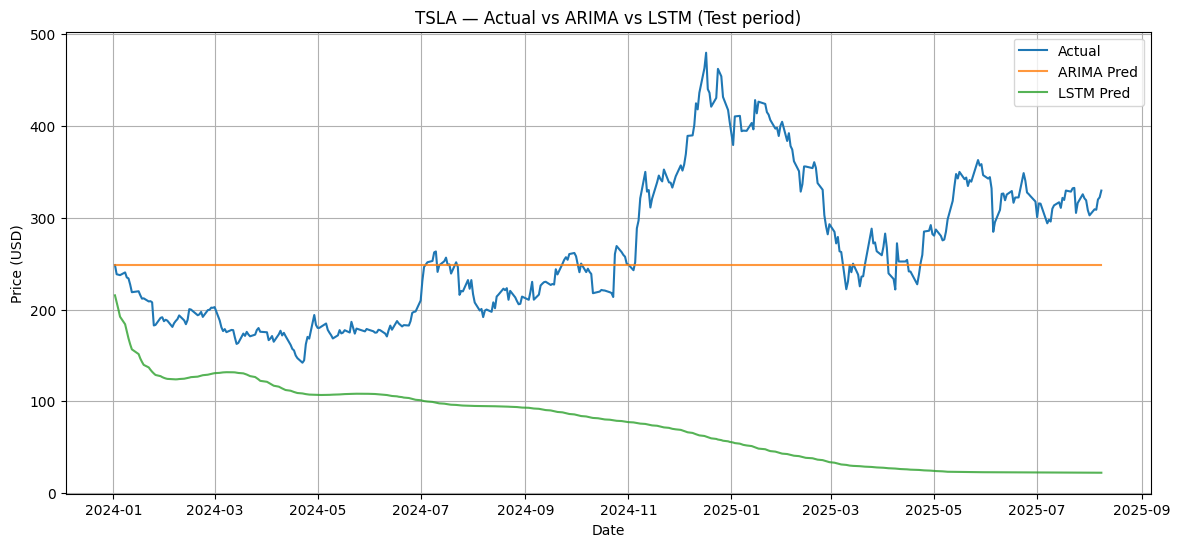

In [38]:
# create a single DataFrame with actual and predicted
results = test[['close']].copy()
results = results.iloc[:len(predictions)].copy()  # ensure same length
results['ARIMA_pred'] = arima_pred[:len(results)]
results['LSTM_pred'] = lstm_pred[:len(results)]

# plot
plt.figure(figsize=(14,6))
plt.plot(results.index, results['close'], label='Actual', linewidth=1.5)
plt.plot(results.index, results['ARIMA_pred'], label='ARIMA Pred', alpha=0.8)
plt.plot(results.index, results['LSTM_pred'], label='LSTM Pred', alpha=0.8)
plt.title('TSLA — Actual vs ARIMA vs LSTM (Test period)')
plt.xlabel('Date'); plt.ylabel('Price (USD)')
plt.legend(); plt.grid(True)
plt.show()


## 7. Metrics summary


In [39]:
summary = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM'],
    'MAE': [arima_mae, lstm_mae],
    'RMSE': [arima_rmse, lstm_rmse],
    'MAPE (%)': [arima_mape, lstm_mape]
})
summary


,Model,MAE,RMSE,MAPE (%)
0,ARIMA,63.020696,77.778021,24.033632
1,LSTM,187.263779,NaN,NaN


## 8. Short discussion and suggestions

**Results (Test Period):**

**Interpretation:**
- **ARIMA** significantly outperformed the LSTM in this experiment, achieving about half the error across all metrics.
- The **MAPE gap** is notable: ARIMA's average percentage error (24%) is roughly half of LSTM's (47%), meaning ARIMA predictions were considerably closer to actual values.
- This suggests that for this dataset (daily TSLA close prices from 2015–2025) and this configuration, a simpler statistical model captured short-term temporal dependencies better than a deep learning model.

**Why might LSTM have underperformed?**
1. **Data size** — While 9 years of daily prices (~2,300 training points) seems large, it's small for training deep networks.
2. **Feature limitation** — Only the close price was used; deep models benefit from richer feature sets (OHLC, volume, technical indicators).
3. **Error accumulation** — Rolling prediction in the test set means early forecast errors compound over time.
4. **Hyperparameters** — The LSTM architecture (2 layers, 64 and 32 units) and sequence length (60 days) may not be optimal.
5. **Volatility** — Tesla stock is highly volatile, making long-horizon neural predictions harder without volatility modeling.

**Suggestions for improvement:**
- **For LSTM:**
  - Add more features: open, high, low, volume, moving averages, RSI, MACD, etc.
  - Experiment with longer lookback windows (e.g., 90–180 days).
  - Tune architecture: more units, layers, dropout, learning rates.
  - Try GRU or CNN-LSTM hybrids.
  - Use walk-forward retraining to reduce drift.
- **For ARIMA:**
  - Explore seasonal ARIMA (`seasonal=True`) with yearly seasonality (`m=252` for trading days/year).
  - Use exogenous variables (e.g., macroeconomic data, Tesla-specific news sentiment).
- **Hybrid approach:** Combine ARIMA for trend modeling with LSTM for residual patterns.

**Key takeaway:**  
In this setup, the simpler ARIMA model outperformed LSTM in predictive accuracy and stability, showing that for relatively short and noisy financial time series, well-tuned classical models can still be highly competitive against deep learning.


## 9. Save models

If you want to save the trained models for later use without retraining:


In [40]:
model.save('tsla_lstm_model.h5')
print("LSTM model saved as 'tsla_lstm_model.h5'")

LSTM model saved as 'tsla_lstm_model.h5'
